In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D # for cnn
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
"""
ImageDataGenerator를 이용하여 Data Augmentation을 통해서 학습 데이터 부족 문제 해결
"""
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
plt.style.use('dark_background')

2024-11-07 18:52:36.532544: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [1]:
pip install pandas


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## dataset preprocessing

In [11]:
import numpy as np
import pandas as pd
import ast

# CSV 파일을 읽어옴
data = pd.read_csv("your_file.csv")

# 빈 리스트로 저장할 변수
images = []
labels = []

for index, row in data.iterrows():
    try:
        # 이미지 데이터가 제대로 포맷되어 있는지 확인하고, 적절히 변환
        img = np.array(ast.literal_eval(row[0]))  # img 데이터가 문자열로 저장되어 있으므로, ast.literal_eval을 사용해 리스트로 변환
    except (ValueError, SyntaxError) as e:
        print(f"Error parsing image data at row {index}: {e}")
        continue

    # 이미지 데이터의 크기가 맞는지 확인
    if img.size == 34 * 26:
        img = img.reshape([34, 26])  # 크기 맞추기
    else:
        print(f"Skipping row {index} due to incorrect image size")
        continue

    # 레이블 설정 (open은 1, close는 0)
    if row[1] == "open":
        label = 1
    elif row[1] == "close":
        label = 0
    else:
        print(f"Skipping row {index} due to unexpected label value: {row[1]}")
        continue
    
    # 리스트에 추가
    images.append(img)
    labels.append(label)

# 이미지를 numpy 배열로 변환
images = np.array(images)
labels = np.array(labels)

# .npy 파일로 저장
np.save("images.npy", images)
np.save("labels.npy", labels)


/var/folders/l4/y_bsqjv51cg_wqy5xcj1b3940000gn/T/ipykernel_26762/356889157.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img = np.array(ast.literal_eval(row[0]))  # img 데이터가 문자열로 저장되어 있으므로, ast.literal_eval을 사용해 리스트로 변환


ValueError: malformed node or string on line 1: <ast.Name object at 0x1414847c0>

## Load Dataset

In [28]:
x_train = np.load('dataset/x_train.npy').astype(np.float32)
y_train = np.load('dataset/y_train.npy').astype(np.float32)
x_val = np.load('dataset/x_val.npy').astype(np.float32)
y_val = np.load('dataset/y_val.npy').astype(np.float32)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)


(2586, 26, 34, 1) (2586, 1)
(288, 26, 34, 1) (288, 1)


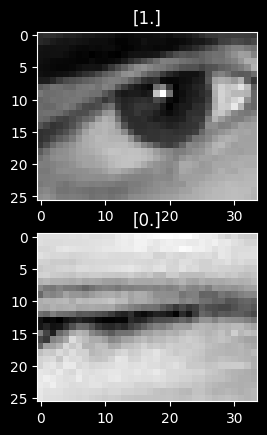

In [31]:
plt.subplot(2, 1, 1)
plt.title(str(y_train[0]))
plt.imshow(x_train[0].reshape((26, 34)), cmap='gray')

plt.subplot(2, 1, 2)
plt.title(str(y_val[4]))
plt.imshow(x_val[4].reshape((26, 34)), cmap='gray')
# imshow는 원하는 사이즈의 픽셀을 원하는 색으로 채워서 만든 그림

## Data Augmentation

In [15]:
train_datagen = ImageDataGenerator(
    rescale=1./255, # 0~255 -> 0~1

    #이후는 for data augmentation
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2 
)

val_datagen = ImageDataGenerator(rescale=1./255)

#데이터 제너레이터 만들기
train_generator = train_datagen.flow(
    x=x_train, y=y_train,
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow(
    x=x_val, y=y_val,
    batch_size=32,
    shuffle=False
)

## Build Model

In [16]:
inputs = Input(shape=(26, 34, 1))

net = Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(inputs)
net = MaxPooling2D(pool_size=2)(net) #차원 축소

net = Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Flatten()(net)

net = Dense(512)(net)
net = Activation('relu')(net)
net = Dense(1)(net)
outputs = Activation('sigmoid')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 26, 34, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 34, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 17, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 880,129 (3.36 MB)

 Trainable params: 880,129 (3.36 MB)

 Non-trainable params: 0 (0.00 B)

## Train

In [21]:
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.fit(
    train_generator, epochs=50, validation_data=val_generator,
    callbacks=[
        ModelCheckpoint('models/%s.keras' % (start_time), monitor='val_acc', save_best_only=True, mode='max', verbose=1),
        ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)
    ]
)

/usr/local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - acc: 0.6994 - loss: 0.5529

/usr/local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_acc improved from -inf to 0.94097, saving model to models/2024_11_07_16_12_13.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - acc: 0.7017 - loss: 0.5503 - val_acc: 0.9410 - val_loss: 0.2233 - learning_rate: 0.0010
Epoch 2/50
80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - acc: 0.8978 - loss: 0.2780
Epoch 2: val_acc improved from 0.94097 to 0.95833, saving model to models/2024_11_07_16_12_13.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - acc: 0.8982 - loss: 0.2770 - val_acc: 0.9583 - val_loss: 0.1184 - learning_rate: 0.0010
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - acc: 0.9256 - loss: 0.1956
Epoch 3: val_acc improved from 0.95833 to 0.96875, saving model to models/2024_11_07_16_12_13.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - acc: 0.9257 - loss: 0.1954 - val_acc: 0.9688 - val_loss: 0.0923 - learning_rate: 0.0010
Epoch 4/50
80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - acc: 0.9537 - loss: 0.1479
Epoch 4: val_acc improved from 0.96875 to 0.97569, saving model to model

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
test acc: 1.0


<Axes: >

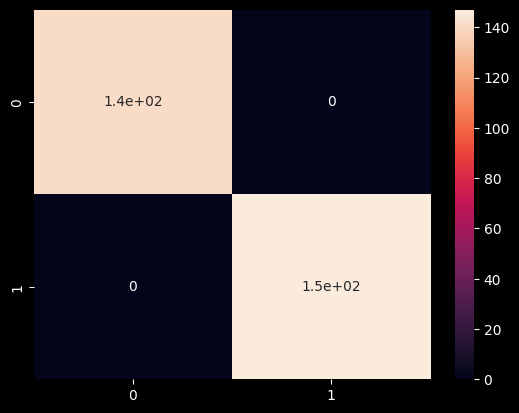

In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

model = load_model('models/%s.keras' % (start_time))

y_pred = model.predict(x_val/255.)
y_pred_logical = (y_pred > 0.5).astype(int)

print ('test acc: %s' % accuracy_score(y_val, y_pred_logical))
cm = confusion_matrix(y_val, y_pred_logical)
sns.heatmap(cm, annot=True)